<a href="https://colab.research.google.com/github/Max-FM/ICG_GEM_Innovation_Workshop_17_Nov_2021/blob/main/submitted_notebooks/ICG_GEM_Innovation_Hack_2021_11_17_MaxFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICG GEM Innovation Hack Hour 17th Nov 2021
### Author: Max Foxley-Marrable

If you are accessing this Colab notebook through the shared Google Drive Folder, please make your own copy by clicking File -> Save a copy in Drive.

## Install rioxarray package

In [13]:
%%capture

!pip install rioxarray

## Import Required Modules

In [110]:
import numpy as np
import pandas as pd
import xarray as xa
import rioxarray as riox


import matplotlib.pyplot as plt
from matplotlib.dates import datestr2num, num2date
import seaborn as sns

from pathlib import Path

In [115]:
sns.set_theme("talk")
sns.set_style("darkgrid")

## Define Functions

In [5]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def make_composite(band_1, band_2, band_3):
    """Converts three raster bands into a composite image"""
    return normalize(np.dstack((band_1, band_2, band_3)))

def make_rgb_composite(raster):
    """Creates an RGB composite image using the input raster."""
    r = raster[2]
    g = raster[1]
    b = raster[0]

    return make_composite(r, g, b)

def calculate_ndvi(raster):
    """Calculates the normalised difference vegetation index using the input raster."""
    r = raster[2]
    nir = raster[3]

    return (nir - r) / (nir + r)

def calculate_ndwi(raster):
    """Calculates the McFeeters (1996) normalised difference water index using the input raster."""
    g = raster[1]
    nir = raster[3]

    return (g - nir) / (g + nir)

## Shamshato Time Series Data

Here I am attempting to extract NDVI and NDWI timeseries data from the Sentinel 2 images. I then present timeseries regression plots showing the general trend of NDVI and NDWI over time.

#### Extracting the Time Series Data

In [122]:
# SUPER hacky way of extracting median NDVI and NDWI from each Sentinel 2 
# image in Shamshato.

# Sets up dummpy lists to be appended to.
median_ndvi = []
median_ndwi = []
date_list = []

# Recursively iterating through each Sentinel 2 image in the Shamshato folder.
for path in Path(f'{base_filepath}/Shamshato').rglob('*/Sentinel_2_SR/*.tif'):
    # Load in raster.
    raster = riox.open_rasterio(path) / 10000
    
    # Extract date from filestring and append to list.
    date_list.append(f"{path.name[:4]}-{path.name[4:6]}-{path.name[6:8]}")
    
    # Calculate median NDVI and NDWI and append to relevant lists.
    median_ndvi.append(
        calculate_ndvi(raster).median()
    )
    median_ndwi.append(
        calculate_ndwi(raster).median()
    )

In [131]:
# Insert extracted data to Pandas DataFrame.
df = pd.DataFrame(
    {
        "date": np.array(date_list),
        "ndvi": np.array(median_ndvi),
        "ndwi": np.array(median_ndwi),
    }
)

# Converts dates to datetime objects.
df.date = pd.to_datetime(df.date) 
# Converts dates to numerical objects for plotting purposes as some plotting 
# functions do not accept datetime objects.
df["datenum"] = datestr2num(dates) 

df

,date,ndvi,ndwi,datenum
0,2019-01-06,0.202787,-0.329239,737065.0
1,2019-01-06,0.175995,-0.321979,737065.0
2,2019-01-09,0.183348,-0.291621,737068.0
3,2019-01-09,0.183054,-0.305473,737068.0
4,2019-01-24,0.178275,-0.290985,737083.0
...,...,...,...,...
585,2021-11-04,0.144623,-0.174336,738098.0
586,2021-11-11,0.241206,-0.348514,738105.0
587,2021-11-11,0.234791,-0.328554,738105.0
588,2021-11-14,0.202589,-0.289973,738108.0


### Plotting Time-Series Regression Plots using Seaborn

In [128]:
@plt.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 2016-05-08"""
    return num2date(x).strftime('%Y-%m-%d')

#### NDVI Timeseries

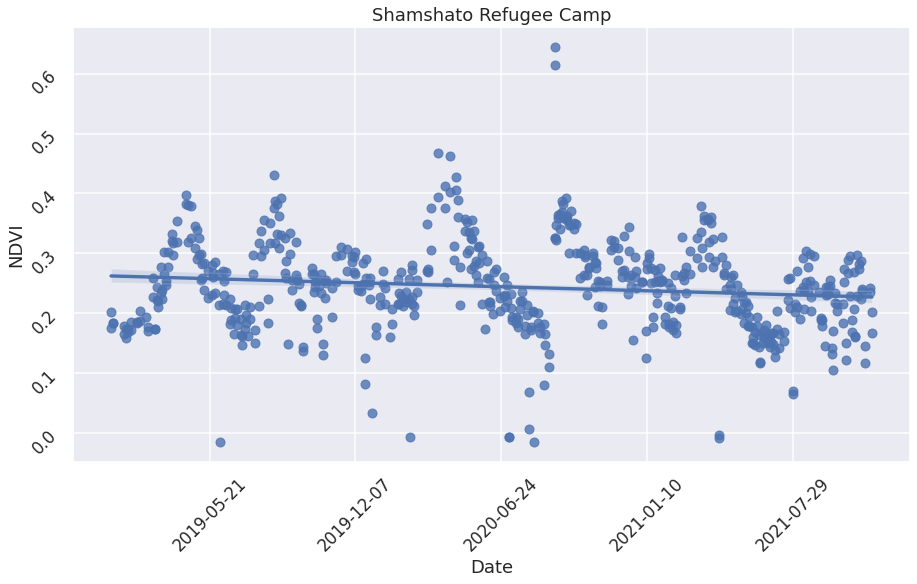

In [132]:
fig, ax = plt.subplots(figsize=(15,8))
sns.regplot(x='datenum', y='ndvi', data=df, ax=ax)
ax.xaxis.set_major_formatter(fake_dates)
ax.tick_params(labelrotation=45)
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.title("Shamshato Refugee Camp")
plt.savefig("/content/drive/Shareddrives/ICG Data Analytics/Events/2021-11-17 Innovation Monthly Meeting/Results/Shamshato_Median_NDVI_Timeseries_Regression.png", bbox_inches="tight")

#### NDWI Timeseries

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


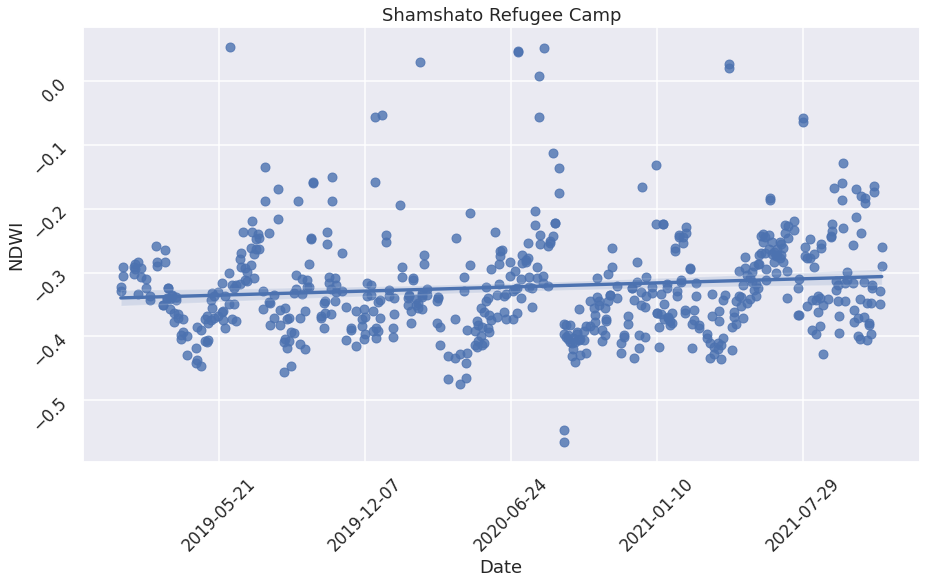

In [133]:
fig, ax = plt.subplots(figsize=(15,8))
sns.regplot('datenum', 'ndwi', data=df, ax=ax)
ax.xaxis.set_major_formatter(fake_dates)
ax.tick_params(labelrotation=45)
plt.xlabel("Date")
plt.ylabel("NDWI")
plt.title("Shamshato Refugee Camp")
plt.savefig("/content/drive/Shareddrives/ICG Data Analytics/Events/2021-11-17 Innovation Monthly Meeting/Results/Shamshato_Median_NDWI_Timeseries_Regression.png", bbox_inches="tight")